# Project 4 
## Power Outages Data Analysis
### Ethan Lam, A17799139

In [99]:
import pandas as pd
import numpy as np
from pathlib import Path
import plotly.express as px
import time
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tabulate import tabulate

### Read in the dataset and clean it

In [100]:
data = pd.read_csv('data/outage.csv')

# Remove first column which is all NaN values
data = data.drop(columns='Unnamed: 0')
data = data.set_index('OBS')
data

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",5:00:00 PM,"Sunday, July 3, 2011",8:00:00 PM,severe weather,NaN,NaN,3060.0,NaN,70000.0,11.60,9.18,6.81,9.28,2332915.0,2114774.0,2113291.0,6562520.0,35.549073,32.225029,32.202431,2308736,276286,10673,2595696,88.9448,10.6440,0.4112,51268,47586,1.077376,1.6,4802,274182,1.751391,2.2,5348119,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",6:38:00 PM,"Sunday, May 11, 2014",6:39:00 PM,intentional attack,vandalism,NaN,1.0,NaN,NaN,12.12,9.71,6.49,9.28,1586986.0,1807756.0,1887927.0,5284231.0,30.032487,34.210389,35.727564,2345860,284978,9898,2640737,88.8335,10.7916,0.3748,53499,49091,1.089792,1.9,5226,291955,1.790002,2.2,5457125,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,"Tuesday, October 26, 2010",8:00:00 PM,"Thursday, October 28, 2010",10:00:00 PM,severe weather,heavy wind,NaN,3000.0,NaN,70000.0,10.87,8.19,6.07,8.15,1467293.0,1801683.0,1951295.0,5222116.0,28.097672,34.501015,37.365983,2300291,276463,10150,2586905,88.9206,10.6870,0.3924,50447,47287,1.066826,2.7,4571,267895,1.706266,2.1,5310903,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Tuesday, June 19, 2012",4:30:00 AM,"Wednesday, June 20, 2012",11:00:00 PM,severe weather,thunderstorm,NaN,2550.0,NaN,68200.0,11.79,9.25,6.71,9.19,1851519.0,1941174.0,1993026.0,5787064.0,31.994099,33.543330,34.439329,2317336,278466,11010,2606813,88.8954,10.6822,0.4224,51598,48156,1.071476,0.6,5364,277627,1.932089,2.2,5380443,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,"Saturday, July 18, 2015",2:00:00 AM,"Sunday, July 19, 2015",7:00:00 AM,severe weather,NaN,NaN,1740.0,250.0,250000.0,13.07,10.16,7.74,10.43,2028875.0,2161612.0,1777937.0,5970339.0,33.982576,36.205850,29.779498,2374674,289044,9812,2673531,88.8216,10.8113,0.3670,54431,49844,1.092027,1.7,4873,292023,1.668704,2.2,5489594,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,"Tuesday, December 6, 2011",8:00:00 AM,"Tuesday, December 6, 2011",8:00:00 PM,public appeal,NaN,NaN,720.0,155.0,34500.0,8.41,7.80,6.20,7.56,488853.0,438133.0,386693.0,1313678.0,37.212544,33.351628,29.435904,330738,60017,3639,394394,83.8598,15.2175,0.9227,57012,47586,1.198083,9.8,934,39067,2.390765,0.5,685326,59.90,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaN,NaN,NaN,NaN,fuel supply emergency,Coal,NaN,NaN,1650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309997,53709,2331,366037,84.6901,14.6731,0.6368,42913,48909,0.877405,3.5,1019,27868,3.656524,0.7,649422,59.90,19.90,2192.2,18

In [101]:
data.isna().sum()

YEAR                          0
MONTH                         9
U.S._STATE                    0
POSTAL.CODE                   0
NERC.REGION                   0
CLIMATE.REGION                6
ANOMALY.LEVEL                 9
CLIMATE.CATEGORY              9
OUTAGE.START.DATE             9
OUTAGE.START.TIME             9
OUTAGE.RESTORATION.DATE      58
OUTAGE.RESTORATION.TIME      58
CAUSE.CATEGORY                0
CAUSE.CATEGORY.DETAIL       471
HURRICANE.NAMES            1462
OUTAGE.DURATION              58
DEMAND.LOSS.MW              705
CUSTOMERS.AFFECTED          443
RES.PRICE                    22
COM.PRICE                    22
IND.PRICE                    22
TOTAL.PRICE                  22
RES.SALES                    22
COM.SALES                    22
IND.SALES                    22
TOTAL.SALES                  22
RES.PERCEN                   22
COM.PERCEN                   22
IND.PERCEN                   22
RES.CUSTOMERS                 0
COM.CUSTOMERS                 0
IND.CUST

Where and when do major power outages tend to occur?

In [102]:
most_power_outage_state = data.groupby('U.S._STATE')['YEAR'].count().sort_values().index[-1]
most_year_power_outage = data.groupby('YEAR')['MONTH'].count().sort_values().index[-1]

In [103]:
most_power_outage_state

'California'

Turn time in columns, OUTAGE.START.DATE and OUTAGE.START.TIME, into type pd.Timestamp and combine the two into OUTAGE.START

In [104]:
most_year_power_outage

np.int64(2011)

In [105]:
data['OUTAGE.START.DATE'] = pd.to_datetime(data['OUTAGE.START.DATE'], format='%A, %B %d, %Y')
data['OUTAGE.START.TIME'] = pd.to_datetime(data['OUTAGE.START.TIME'], format='%I:%M:%S %p').dt.time

In [106]:
data['OUTAGE.START'] = data['OUTAGE.START.DATE'].dt.strftime('%A, %B %d, %Y') + ' ' + data['OUTAGE.START.TIME'].astype(str)
data

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START
OBS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,17:00:00,"Sunday, July 3, 2011",8:00:00 PM,severe weather,NaN,NaN,3060.0,NaN,70000.0,11.60,9.18,6.81,9.28,2332915.0,2114774.0,2113291.0,6562520.0,35.549073,32.225029,32.202431,2308736,276286,10673,2595696,88.9448,10.6440,0.4112,51268,47586,1.077376,1.6,4802,274182,1.751391,2.2,5348119,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Friday, July 01, 2011 17:00:00"
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,18:38:00,"Sunday, May 11, 2014",6:39:00 PM,intentional attack,vandalism,NaN,1.0,NaN,NaN,12.12,9.71,6.49,9.28,1586986.0,1807756.0,1887927.0,5284231.0,30.032487,34.210389,35.727564,2345860,284978,9898,2640737,88.8335,10.7916,0.3748,53499,49091,1.089792,1.9,5226,291955,1.790002,2.2,5457125,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Sunday, May 11, 2014 18:38:00"
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,20:00:00,"Thursday, October 28, 2010",10:00:00 PM,severe weather,heavy wind,NaN,3000.0,NaN,70000.0,10.87,8.19,6.07,8.15,1467293.0,1801683.0,1951295.0,5222116.0,28.097672,34.501015,37.365983,2300291,276463,10150,2586905,88.9206,10.6870,0.3924,50447,47287,1.066826,2.7,4571,267895,1.706266,2.1,5310903,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Tuesday, October 26, 2010 20:00:00"
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,04:30:00,"Wednesday, June 20, 2012",11:00:00 PM,severe weather,thunderstorm,NaN,2550.0,NaN,68200.0,11.79,9.25,6.71,9.19,1851519.0,1941174.0,1993026.0,5787064.0,31.994099,33.543330,34.439329,2317336,278466,11010,2606813,88.8954,10.6822,0.4224,51598,48156,1.071476,0.6,5364,277627,1.932089,2.2,5380443,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Tuesday, June 19, 2012 04:30:00"
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,02:00:00,"Sunday, July 19, 2015",7:00:00 AM,severe weather,NaN,NaN,1740.0,250.0,250000.0,13.07,10.16,7.74,10.43,2028875.0,2161612.0,1777937.0,5970339.0,33.982576,36.205850,29.779498,2374674,289044,9812,2673531,88.8216,10.8113,0.3670,54431,49844,1.092027,1.7,4873,292023,1.668704,2.2,5489594,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Saturday, July 18, 2015 02:00:00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06,08:00:00,"Tuesday, December 6, 2011",8:00:00 PM,public appeal,NaN,NaN,720.0,155.0,34500.0,8.41,7.80,6.20,7.56,488853.0,438133.0,386693.0,1313678.0,37.212544,33.351628,29.435904,330738,60017,3639,394394,83.8598,15.2175,0.9227,57012,47586,1.198083,9.8,934,39067,2.390765,0.5,685326,59.90,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,"Tuesday, December 06, 2011 08:00:00"
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaT,NaT,NaN,NaN,fuel supply emergency,Coal,NaN,NaN,1650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Combine OUTAGE.RESTORATION.DATE and OUTAGE.RESTORATION.TIME into a new column, OUTAGE.RESTORATION

In [107]:
data['OUTAGE.RESTORATION.DATE'] = pd.to_datetime(data['OUTAGE.RESTORATION.DATE'], format='%A, %B %d, %Y')
data['OUTAGE.RESTORATION.TIME'] = pd.to_datetime(data['OUTAGE.RESTORATION.TIME'], format='%I:%M:%S %p').dt.time
data['OUTAGE.RESTORATION'] = data['OUTAGE.RESTORATION.DATE'].dt.strftime('%A, %B %d, %Y') + ' ' + data['OUTAGE.RESTORATION.TIME'].astype(str)
data

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
OBS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,17:00:00,2011-07-03,20:00:00,severe weather,NaN,NaN,3060.0,NaN,70000.0,11.60,9.18,6.81,9.28,2332915.0,2114774.0,2113291.0,6562520.0,35.549073,32.225029,32.202431,2308736,276286,10673,2595696,88.9448,10.6440,0.4112,51268,47586,1.077376,1.6,4802,274182,1.751391,2.2,5348119,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Friday, July 01, 2011 17:00:00","Sunday, July 03, 2011 20:00:00"
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,18:38:00,2014-05-11,18:39:00,intentional attack,vandalism,NaN,1.0,NaN,NaN,12.12,9.71,6.49,9.28,1586986.0,1807756.0,1887927.0,5284231.0,30.032487,34.210389,35.727564,2345860,284978,9898,2640737,88.8335,10.7916,0.3748,53499,49091,1.089792,1.9,5226,291955,1.790002,2.2,5457125,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Sunday, May 11, 2014 18:38:00","Sunday, May 11, 2014 18:39:00"
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,20:00:00,2010-10-28,22:00:00,severe weather,heavy wind,NaN,3000.0,NaN,70000.0,10.87,8.19,6.07,8.15,1467293.0,1801683.0,1951295.0,5222116.0,28.097672,34.501015,37.365983,2300291,276463,10150,2586905,88.9206,10.6870,0.3924,50447,47287,1.066826,2.7,4571,267895,1.706266,2.1,5310903,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Tuesday, October 26, 2010 20:00:00","Thursday, October 28, 2010 22:00:00"
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,04:30:00,2012-06-20,23:00:00,severe weather,thunderstorm,NaN,2550.0,NaN,68200.0,11.79,9.25,6.71,9.19,1851519.0,1941174.0,1993026.0,5787064.0,31.994099,33.543330,34.439329,2317336,278466,11010,2606813,88.8954,10.6822,0.4224,51598,48156,1.071476,0.6,5364,277627,1.932089,2.2,5380443,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Tuesday, June 19, 2012 04:30:00","Wednesday, June 20, 2012 23:00:00"
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,02:00:00,2015-07-19,07:00:00,severe weather,NaN,NaN,1740.0,250.0,250000.0,13.07,10.16,7.74,10.43,2028875.0,2161612.0,1777937.0,5970339.0,33.982576,36.205850,29.779498,2374674,289044,9812,2673531,88.8216,10.8113,0.3670,54431,49844,1.092027,1.7,4873,292023,1.668704,2.2,5489594,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Saturday, July 18, 2015 02:00:00","Sunday, July 19, 2015 07:00:00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06,08:00:00,2011-12-06,20:00:00,public appeal,NaN,NaN,720.0,155.0,34500.0,8.41,7.80,6.20,7.56,488853.0,438133.0,386693.0,1313678.0,37.212544,33.351628,29.435904,330738,60017,3639,394394,83.8598,15.2175,0.9227,57012,47586,1.198083,9.8,934,39067,2.390765,0.5,685326,59.90,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,"Tuesday, December 06, 2011 08:00:00","Tuesday, December 06, 2011 20:00:00"
1531,2006,NaN,North Dakota,ND,MR

In [ ]:
relevant = data[['YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE', 'NERC.REGION', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'RES.SALES', 'OUTAGE.START', 'OUTAGE.RESTORATION', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'RES.SALES', 'IND.SALES', 'COM.SALES', 'TOTAL.PRICE', 'TOTAL.SALES', 'TOTAL.CUSTOMERS', 'POPPCT_URBAN', 'POPDEN_URBAN', 'AREAPCT_URBAN']]


In [110]:
pd.set_option('display.max_columns', None)
relevant

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,RES.SALES,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.SALES,IND.SALES,COM.SALES,TOTAL.PRICE,TOTAL.SALES,TOTAL.CUSTOMERS,POPPCT_URBAN,POPDEN_URBAN,AREAPCT_URBAN
OBS,,,,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,severe weather,NaN,2332915.0,"Friday, July 01, 2011 17:00:00","Sunday, July 03, 2011 20:00:00",3060.0,NaN,70000.0,2332915.0,2113291.0,2114774.0,9.28,6562520.0,2595696,73.27,2279.0,2.14
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,intentional attack,vandalism,1586986.0,"Sunday, May 11, 2014 18:38:00","Sunday, May 11, 2014 18:39:00",1.0,NaN,NaN,1586986.0,1887927.0,1807756.0,9.28,5284231.0,2640737,73.27,2279.0,2.14
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,severe weather,heavy wind,1467293.0,"Tuesday, October 26, 2010 20:00:00","Thursday, October 28, 2010 22:00:00",3000.0,NaN,70000.0,1467293.0,1951295.0,1801683.0,8.15,5222116.0,2586905,73.27,2279.0,2.14
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,severe weather,thunderstorm,1851519.0,"Tuesday, June 19, 2012 04:30:00","Wednesday, June 20, 2012 23:00:00",2550.0,NaN,68200.0,1851519.0,1993026.0,1941174.0,9.19,5787064.0,2606813,73.27,2279.0,2.14
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,severe weather,NaN,2028875.0,"Saturday, July 18, 2015 02:00:00","Sunday, July 19, 2015 07:00:00",1740.0,250.0,250000.0,2028875.0,1777937.0,2161612.0,10.43,5970339.0,2673531,73.27,2279.0,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,public appeal,NaN,488853.0,"Tuesday, December 06, 2011 08:00:00","Tuesday, December 06, 2011 20:00:00",720.0,155.0,34500.0,488853.0,386693.0,438133.0,7.56,1313678.0,394394,59.90,2192.2,0.27
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,fuel supply emergency,Coal,NaN,NaN,NaN,NaN,1650.0,NaN,NaN,NaN,NaN,NaN,NaN,366037,59.90,2192.2,0.27
1532,2009,8.0,South Dakota,SD,RFC,West North Central,0.5,islanding,NaN,337874.0,"Saturday, August 29, 2009 22:54:00","Saturday, August 29, 2009 23:53:00",59.0,84.0,NaN,337874.0,215406.0,370771.0,7.67,924051.0,436229,56.65,2038.3,0.30


In [111]:
def standardize(df, col):
    return (df[col] - df[col].mean()) / df[col].std()

In [112]:
relevant['RES.SALES'] = standardize(data, 'RES.SALES')
relevant['IND.SALES'] = standardize(data, 'IND.SALES')
relevant['COM.SALES'] = standardize(data, 'COM.SALES')
relevant

C:\Users\Stikes PC\AppData\Local\Temp\ipykernel_10424\3675664561.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Stikes PC\AppData\Local\Temp\ipykernel_10424\3675664561.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Stikes PC\AppData\Local\Temp\ipykernel_10424\3675664561.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,RES.SALES,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.SALES,IND.SALES,COM.SALES,TOTAL.PRICE,TOTAL.SALES,TOTAL.CUSTOMERS,POPPCT_URBAN,POPDEN_URBAN,AREAPCT_URBAN
OBS,,,,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,severe weather,NaN,-0.594363,"Friday, July 01, 2011 17:00:00","Sunday, July 03, 2011 20:00:00",3060.0,NaN,70000.0,-0.594363,-0.308476,-0.660847,9.28,6562520.0,2595696,73.27,2279.0,2.14
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,intentional attack,vandalism,-0.815220,"Sunday, May 11, 2014 18:38:00","Sunday, May 11, 2014 18:39:00",1.0,NaN,NaN,-0.815220,-0.410267,-0.748638,9.28,5284231.0,2640737,73.27,2279.0,2.14
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,severe weather,heavy wind,-0.850659,"Tuesday, October 26, 2010 20:00:00","Thursday, October 28, 2010 22:00:00",3000.0,NaN,70000.0,-0.850659,-0.381646,-0.750375,8.15,5222116.0,2586905,73.27,2279.0,2.14
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,severe weather,thunderstorm,-0.736896,"Tuesday, June 19, 2012 04:30:00","Wednesday, June 20, 2012 23:00:00",2550.0,NaN,68200.0,-0.736896,-0.362797,-0.710488,9.19,5787064.0,2606813,73.27,2279.0,2.14
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,severe weather,NaN,-0.684384,"Saturday, July 18, 2015 02:00:00","Sunday, July 19, 2015 07:00:00",1740.0,250.0,250000.0,-0.684384,-0.459947,-0.647453,10.43,5970339.0,2673531,73.27,2279.0,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,public appeal,NaN,-1.140358,"Tuesday, December 06, 2011 08:00:00","Tuesday, December 06, 2011 20:00:00",720.0,155.0,34500.0,-1.140358,-1.088336,-1.140282,7.56,1313678.0,394394,59.90,2192.2,0.27
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,fuel supply emergency,Coal,NaN,NaN,NaN,NaN,1650.0,NaN,NaN,NaN,NaN,NaN,NaN,366037,59.90,2192.2,0.27
1532,2009,8.0,South Dakota,SD,RFC,West North Central,0.5,islanding,NaN,-1.185060,"Saturday, August 29, 2009 22:54:00","Saturday, August 29, 2009 23:53:00",59.0,84.0,NaN,-1.185060,-1.165702,-1.159544,7.67,924051.0,436229,56.65,2038.3,0.30


In [113]:
relevant = relevant.copy()
relevant['MONTH'] = pd.to_datetime(data['MONTH'], format='%m').dt.month_name().str.slice(stop=3)
print(relevant[['MONTH', 'U.S._STATE', 'CAUSE.CATEGORY', 'OUTAGE.START', 'IND.SALES', 'COM.SALES']].head().to_markdown(index=False))

| MONTH   | U.S._STATE   | CAUSE.CATEGORY     | OUTAGE.START                       |   IND.SALES |   COM.SALES |
|:--------|:-------------|:-------------------|:-----------------------------------|------------:|------------:|
| Jul     | Minnesota    | severe weather     | Friday, July 01, 2011 17:00:00     |   -0.308476 |   -0.660847 |
| May     | Minnesota    | intentional attack | Sunday, May 11, 2014 18:38:00      |   -0.410267 |   -0.748638 |
| Oct     | Minnesota    | severe weather     | Tuesday, October 26, 2010 20:00:00 |   -0.381646 |   -0.750375 |
| Jun     | Minnesota    | severe weather     | Tuesday, June 19, 2012 04:30:00    |   -0.362797 |   -0.710488 |
| Jul     | Minnesota    | severe weather     | Saturday, July 18, 2015 02:00:00   |   -0.459947 |   -0.647453 |


Now that our data is cleaned up, let's explore variables that would have
correlation to power outages

In [120]:
outages_per_state = relevant.groupby('U.S._STATE')['YEAR'].count().reset_index()
outages_per_state

,U.S._STATE,YEAR
0,Alabama,6
1,Alaska,1
2,Arizona,28
3,Arkansas,25
4,California,210
5,Colorado,15
6,Connecticut,18
7,Delaware,41
8,District of Columbia,10
9,Florida,45


In [122]:
us_states_geo = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
m = folium.Map(location=[37.8, -96], zoom_start=5)
folium.Choropleth(
    geo_data=us_states_geo,
    name="choropleth",
    data=outages_per_state,
    columns=['U.S._STATE', 'YEAR'],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Power Outages by State"
).add_to(m)

m

In [123]:
m.save("power_outages_choropleth.html")

In [143]:
num_causes = relevant.groupby('CAUSE.CATEGORY')[['YEAR']].count().sort_values(by='YEAR').rename(columns={'YEAR': 'Count'})
causes = px.bar(num_causes, title='Number of Outages Per Cause')
causes.show()
causes.write_html('causes_count.html')

In [144]:
num_states = relevant.groupby('U.S._STATE')['YEAR'].count().sort_values()
states = px.bar(num_states)
states.show()

In [145]:
num_year = relevant.groupby('YEAR')[['MONTH']].count().rename(columns={'MONTH': 'COUNT'})
year = px.line(num_year, title='Number of Outages Per Year')
year.show()
year.write_html('outages_yearly_count.html')

In [147]:
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
num_month = relevant.groupby('MONTH')[['YEAR']].count().rename(columns={'YEAR': 'COUNT'})
num_month = num_month.sort_index(key=lambda x: x.map(lambda month: month_order.index(month)))
month = px.line(num_month, title='Number of Outages Per Month')
month.show()
month.write_html('outages_monthly_count.html')

Now move on to two variable analysis

In [163]:
relevant.isna().sum()

YEAR                       0
MONTH                      9
U.S._STATE                 0
POSTAL.CODE                0
NERC.REGION                0
CLIMATE.REGION             6
ANOMALY.LEVEL              9
CAUSE.CATEGORY             0
CAUSE.CATEGORY.DETAIL    471
RES.SALES                 22
OUTAGE.START               9
OUTAGE.RESTORATION        58
OUTAGE.DURATION           58
DEMAND.LOSS.MW           705
CUSTOMERS.AFFECTED       443
RES.SALES                 22
IND.SALES                 22
COM.SALES                 22
TOTAL.PRICE               22
TOTAL.SALES               22
TOTAL.CUSTOMERS            0
POPPCT_URBAN               0
POPDEN_URBAN               0
AREAPCT_URBAN              0
dtype: int64

In [167]:
duration_vs_sales = px.scatter(relevant, x='TOTAL.SALES', y='OUTAGE.DURATION', title='Outage Duration (minutes) vs Total Sales (megawatt/hour)', labels={'OUTAGE.DURATION': "Outage Duration (minutes)", 'TOTAL.SALES': 'Total sales (megawatt/hour)'})
duration_vs_sales.show()
duration_vs_sales.write_html('duration_vs_sales.html')

In [ ]:
demandloss_vs_cause = px.scatter(relevant, x='CUSTOMERS.AFFECTED', y='OUTAGE.DURATION')
demandloss_vs_cause

In [175]:
duration_vs_cause = px.scatter(relevant, x='CAUSE.CATEGORY', y='OUTAGE.DURATION',  title='Outage Duration (minutes) vs Cause Category', labels={'OUTAGE.DURATION': "Outage Duration (minutes)", 'CAUSE.CATEGORY': 'Cause Category'})
duration_vs_cause
duration_vs_cause.write_html("duration_vs_cause.html")

In [19]:
relevant

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,RES.SALES,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,TOTAL.PRICE,TOTAL.SALES,TOTAL.CUSTOMERS,POPPCT_URBAN,POPDEN_URBAN,AREAPCT_URBAN
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,July,Minnesota,MN,MRO,East North Central,-0.3,severe weather,NaN,2332915.0,"Friday, July 01, 2011 17:00:00","Sunday, July 03, 2011 20:00:00",3060.0,NaN,70000.0,9.28,6562520.0,2595696,73.27,2279.0,2.14
2,2014,May,Minnesota,MN,MRO,East North Central,-0.1,intentional attack,vandalism,1586986.0,"Sunday, May 11, 2014 18:38:00","Sunday, May 11, 2014 18:39:00",1.0,NaN,NaN,9.28,5284231.0,2640737,73.27,2279.0,2.14
3,2010,October,Minnesota,MN,MRO,East North Central,-1.5,severe weather,heavy wind,1467293.0,"Tuesday, October 26, 2010 20:00:00","Thursday, October 28, 2010 22:00:00",3000.0,NaN,70000.0,8.15,5222116.0,2586905,73.27,2279.0,2.14
4,2012,June,Minnesota,MN,MRO,East North Central,-0.1,severe weather,thunderstorm,1851519.0,"Tuesday, June 19, 2012 04:30:00","Wednesday, June 20, 2012 23:00:00",2550.0,NaN,68200.0,9.19,5787064.0,2606813,73.27,2279.0,2.14
5,2015,July,Minnesota,MN,MRO,East North Central,1.2,severe weather,NaN,2028875.0,"Saturday, July 18, 2015 02:00:00","Sunday, July 19, 2015 07:00:00",1740.0,250.0,250000.0,10.43,5970339.0,2673531,73.27,2279.0,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,December,North Dakota,ND,MRO,West North Central,-0.9,public appeal,NaN,488853.0,"Tuesday, December 06, 2011 08:00:00","Tuesday, December 06, 2011 20:00:00",720.0,155.0,34500.0,7.56,1313678.0,394394,59.90,2192.2,0.27
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,fuel supply emergency,Coal,NaN,NaN,NaN,NaN,1650.0,NaN,NaN,NaN,366037,59.90,2192.2,0.27
1532,2009,August,South Dakota,SD,RFC,West North Central,0.5,islanding,NaN,337874.0,"Saturday, August 29, 2009 22:54:00","Saturday, August 29, 2009 23:53:00",59.0,84.0,NaN,7.67,924051.0,436229,56.65,2038.3,0.30


Examining aggregate statistics


In [20]:
# mean of outage duration and customers affected for each state
relevant.groupby('U.S._STATE')[['OUTAGE.DURATION', 'CUSTOMERS.AFFECTED']].mean()

,OUTAGE.DURATION,CUSTOMERS.AFFECTED
U.S._STATE,,
Alabama,1152.800000,94328.800000
Alaska,NaN,14273.000000
Arizona,4552.920000,64402.666667
Arkansas,1514.360000,47673.846154
California,1666.338384,201365.716535
Colorado,901.071429,41060.636364
Connecticut,1278.833333,60339.230769
Delaware,144.925000,3475.000000
District of Columbia,4303.600000,194709.222222


In [182]:
# number of each cause category for each climate region

region_category = relevant.groupby(['CLIMATE.REGION', 'CAUSE.CATEGORY'])[['YEAR']].count().rename(columns={'YEAR':'Count'})
region_category_pivot = region_category.pivot_table(index='CLIMATE.REGION', columns='CAUSE.CATEGORY')
print(region_category_pivot.to_markdown())

| CLIMATE.REGION     |   ('Count', 'equipment failure') |   ('Count', 'fuel supply emergency') |   ('Count', 'intentional attack') |   ('Count', 'islanding') |   ('Count', 'public appeal') |   ('Count', 'severe weather') |   ('Count', 'system operability disruption') |
|:-------------------|---------------------------------:|-------------------------------------:|----------------------------------:|-------------------------:|-----------------------------:|------------------------------:|---------------------------------------------:|
| Central            |                                7 |                                    4 |                                38 |                        3 |                            2 |                           135 |                                           11 |
| East North Central |                                3 |                                    5 |                                20 |                        1 |                            2 |

In [22]:
relevant

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,RES.SALES,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,TOTAL.PRICE,TOTAL.SALES,TOTAL.CUSTOMERS,POPPCT_URBAN,POPDEN_URBAN,AREAPCT_URBAN
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,July,Minnesota,MN,MRO,East North Central,-0.3,severe weather,NaN,2332915.0,"Friday, July 01, 2011 17:00:00","Sunday, July 03, 2011 20:00:00",3060.0,NaN,70000.0,9.28,6562520.0,2595696,73.27,2279.0,2.14
2,2014,May,Minnesota,MN,MRO,East North Central,-0.1,intentional attack,vandalism,1586986.0,"Sunday, May 11, 2014 18:38:00","Sunday, May 11, 2014 18:39:00",1.0,NaN,NaN,9.28,5284231.0,2640737,73.27,2279.0,2.14
3,2010,October,Minnesota,MN,MRO,East North Central,-1.5,severe weather,heavy wind,1467293.0,"Tuesday, October 26, 2010 20:00:00","Thursday, October 28, 2010 22:00:00",3000.0,NaN,70000.0,8.15,5222116.0,2586905,73.27,2279.0,2.14
4,2012,June,Minnesota,MN,MRO,East North Central,-0.1,severe weather,thunderstorm,1851519.0,"Tuesday, June 19, 2012 04:30:00","Wednesday, June 20, 2012 23:00:00",2550.0,NaN,68200.0,9.19,5787064.0,2606813,73.27,2279.0,2.14
5,2015,July,Minnesota,MN,MRO,East North Central,1.2,severe weather,NaN,2028875.0,"Saturday, July 18, 2015 02:00:00","Sunday, July 19, 2015 07:00:00",1740.0,250.0,250000.0,10.43,5970339.0,2673531,73.27,2279.0,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,December,North Dakota,ND,MRO,West North Central,-0.9,public appeal,NaN,488853.0,"Tuesday, December 06, 2011 08:00:00","Tuesday, December 06, 2011 20:00:00",720.0,155.0,34500.0,7.56,1313678.0,394394,59.90,2192.2,0.27
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,fuel supply emergency,Coal,NaN,NaN,NaN,NaN,1650.0,NaN,NaN,NaN,366037,59.90,2192.2,0.27
1532,2009,August,South Dakota,SD,RFC,West North Central,0.5,islanding,NaN,337874.0,"Saturday, August 29, 2009 22:54:00","Saturday, August 29, 2009 23:53:00",59.0,84.0,NaN,7.67,924051.0,436229,56.65,2038.3,0.30


The column 'CAUSE.CATEGORY' missingness could be NMAR for the reason that a cause for the outage could not have been determined. 

We will now test if 'CAUSE.CATEGORY.DETAIL' and 'MONTH' missingness depends on 'CAUSE.CATEGORY' using permutation tests.
 
Our test statistic for missingness both columns will be the absolute difference in missingness rates between the category with the highest missingness rate and the category with the lowest missingness rate. We will use a significance level of 0.01



In [45]:
missing_columns = relevant[['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'MONTH']].copy()


In [46]:
missing_columns['detail_missing'] = missing_columns['CAUSE.CATEGORY.DETAIL'].isna()
missing_columns['month_missing'] = missing_columns['MONTH'].isna()

Permutation test for cause category detail

In [47]:
def max_min_test_stat(ser):
    return abs(max(ser) - min(ser))

In [48]:
detail_groupby = missing_columns.groupby('CAUSE.CATEGORY')['detail_missing'].mean()
obs_detail = max_min_test_stat(detail_groupby)
obs_detail

0.8851674641148325

General permutation function

In [49]:
def permutation(df, col, bool_col, test_stat):
    test = df.copy()
    stats = []
    for _ in range(1000):
        test['permutate'] = np.random.permutation(df[bool_col])
        observed = test_stat(test.groupby(col)['permutate'].mean())
        stats.append(observed)

    return np.array(stats)

In [50]:
stats_details = permutation(missing_columns, 'CAUSE.CATEGORY', 'detail_missing', max_min_test_stat)
p_val_details = np.mean(stats_details >= obs_detail)
p_val_details

np.float64(0.0)

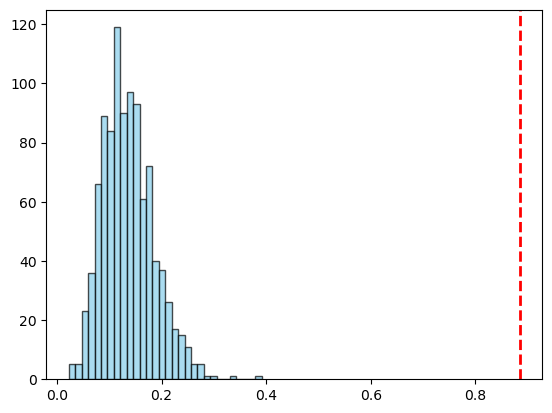

In [59]:
plt.hist(stats_details, bins=30, color='skyblue', edgecolor='k', alpha=0.7, label='Permutation Distribution')
plt.axvline(obs_detail, color='red', linestyle='--', linewidth=2)

We have a p_val of 0, which means we can reject the null hypothesis of no dependence between the missingness of 'CAUSE.CATEGORY.DETAIL' and 'CAUSE.CATEGORY'. These two columns are highly likely to be dependent on one another.

Now, move on to test if the missingness of 'CUSTOMERS.AFFECTED' is dependent on 'CAUSE.CATEGORY.DETAIL'.

In [54]:
stats_month = permutation(missing_columns, 'CAUSE.CATEGORY', 'month_missing', max_min_test_stat)
obs_month = max_min_test_stat(missing_columns.groupby('CAUSE.CATEGORY')['month_missing'].mean())
p_val_month = np.mean(stats_month >= obs_month)
p_val_month

np.float64(0.017)

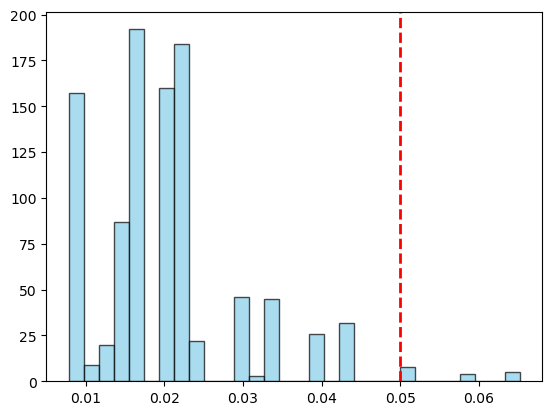

In [60]:
plt.hist(stats_month, bins=30, color='skyblue', edgecolor='k', alpha=0.7, label='Permutation Distribution')
plt.axvline(obs_month, color='red', linestyle='--', linewidth=2)

We have a p_val of ~0.017 which is greater than our significance level of 0.01. We cannot reject the null hypothesis (Month's missingness is not dependent on Cause.Category)

#### Now moving on to testing if the duration of California power outages are different from all other states' power outages

Null Hypothesis: On average, the durations of California power outages is the same as all other states' power outages.

Alternate Hypothesis: On average, the durations of California power outages is different than all other states' power outages.

For our test statistic, we will use a difference in means.

For our significance value, we will use a = 0.05 because this is a general exploratory analysis

In [67]:
state_duration = relevant.copy()[['U.S._STATE', 'OUTAGE.DURATION']]
state_duration

,U.S._STATE,OUTAGE.DURATION
OBS,,
1,Minnesota,3060.0
2,Minnesota,1.0
3,Minnesota,3000.0
4,Minnesota,2550.0
5,Minnesota,1740.0
...,...,...
1530,North Dakota,720.0
1531,North Dakota,NaN
1532,South Dakota,59.0


In [81]:
california_duration_mean = state_duration[state_duration['U.S._STATE'] == 'California']['OUTAGE.DURATION'].mean()
california_duration_mean
every_other_duration_mean = state_duration[state_duration['U.S._STATE'] != 'California']['OUTAGE.DURATION'].mean()
every_other_duration_mean

obs_duration = np.abs(california_duration_mean - every_other_duration_mean)
obs_duration

np.float64(1107.6467491819603)

In [ ]:
test_stats = []
test_df = state_duration.copy()
for _ in range(1000):
    test_df['permutation'] = np.random.permutation(state_duration['OUTAGE.DURATION'])
    cali_mean = test_df[test_df['U.S._STATE'] == 'California']['permutation'].mean()
    every_other_mean =  test_df[test_df['U.S._STATE'] != 'California']['permutation'].mean()
    test_obs = np.abs(cali_mean - every_other_mean)
    test_stats.append(test_obs)

p_val_duration = np.mean(test_stats >= obs_duration)
p_val_duration

np.float64(0.016)

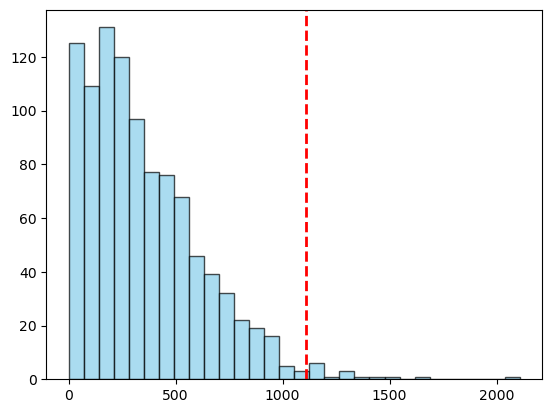

In [83]:
plt.hist(test_stats, bins=30, color='skyblue', edgecolor='k', alpha=0.7, label='Permutation Distribution')
plt.axvline(obs_duration, color='red', linestyle='--', linewidth=2)

### We will now build a model to predict the cause of a power outage.

Our baseline model will be a logistic regression model. It will estimate the probability of a binary outcome based on relevant variables.

For our features, we will use 'OUTAGE.DURATION' and 'CLIMATE.REGION'. 

I chose outage.duration because I noticed that a longer duration of the outage usually is caused by severe weather, while shorter durations are caused by vandalism and islanding.

I chose climate.region because usually some climates recieve more severe weather storms than others and may help predict our cause. 

In [92]:
relevant

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,RES.SALES,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,TOTAL.PRICE,TOTAL.SALES,TOTAL.CUSTOMERS,POPPCT_URBAN,POPDEN_URBAN,AREAPCT_URBAN
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,July,Minnesota,MN,MRO,East North Central,-0.3,severe weather,NaN,2332915.0,"Friday, July 01, 2011 17:00:00","Sunday, July 03, 2011 20:00:00",3060.0,NaN,70000.0,9.28,6562520.0,2595696,73.27,2279.0,2.14
2,2014,May,Minnesota,MN,MRO,East North Central,-0.1,intentional attack,vandalism,1586986.0,"Sunday, May 11, 2014 18:38:00","Sunday, May 11, 2014 18:39:00",1.0,NaN,NaN,9.28,5284231.0,2640737,73.27,2279.0,2.14
3,2010,October,Minnesota,MN,MRO,East North Central,-1.5,severe weather,heavy wind,1467293.0,"Tuesday, October 26, 2010 20:00:00","Thursday, October 28, 2010 22:00:00",3000.0,NaN,70000.0,8.15,5222116.0,2586905,73.27,2279.0,2.14
4,2012,June,Minnesota,MN,MRO,East North Central,-0.1,severe weather,thunderstorm,1851519.0,"Tuesday, June 19, 2012 04:30:00","Wednesday, June 20, 2012 23:00:00",2550.0,NaN,68200.0,9.19,5787064.0,2606813,73.27,2279.0,2.14
5,2015,July,Minnesota,MN,MRO,East North Central,1.2,severe weather,NaN,2028875.0,"Saturday, July 18, 2015 02:00:00","Sunday, July 19, 2015 07:00:00",1740.0,250.0,250000.0,10.43,5970339.0,2673531,73.27,2279.0,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,December,North Dakota,ND,MRO,West North Central,-0.9,public appeal,NaN,488853.0,"Tuesday, December 06, 2011 08:00:00","Tuesday, December 06, 2011 20:00:00",720.0,155.0,34500.0,7.56,1313678.0,394394,59.90,2192.2,0.27
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,fuel supply emergency,Coal,NaN,NaN,NaN,NaN,1650.0,NaN,NaN,NaN,366037,59.90,2192.2,0.27
1532,2009,August,South Dakota,SD,RFC,West North Central,0.5,islanding,NaN,337874.0,"Saturday, August 29, 2009 22:54:00","Saturday, August 29, 2009 23:53:00",59.0,84.0,NaN,7.67,924051.0,436229,56.65,2038.3,0.30


To start, we must impute missing values in our features.

For the outage column, I will use the median. For the climate column, I will use the mode.

In [117]:
df = relevant.copy()[['CAUSE.CATEGORY', 'CLIMATE.REGION', 'OUTAGE.DURATION']]
df['imputed_climate'] = df['CLIMATE.REGION'].fillna(df['CLIMATE.REGION'].value_counts().index[0])
df['imputed_durations'] = df['OUTAGE.DURATION'].fillna(df['OUTAGE.DURATION'].mean())
df

,CAUSE.CATEGORY,CLIMATE.REGION,OUTAGE.DURATION,imputed_climate,imputed_durations
OBS,,,,,
1,severe weather,East North Central,3060.0,East North Central,3060.000000
2,intentional attack,East North Central,1.0,East North Central,1.000000
3,severe weather,East North Central,3000.0,East North Central,3000.000000
4,severe weather,East North Central,2550.0,East North Central,2550.000000
5,severe weather,East North Central,1740.0,East North Central,1740.000000
...,...,...,...,...,...
1530,public appeal,West North Central,720.0,West North Central,720.000000
1531,fuel supply emergency,West North Central,NaN,West North Central,2625.398374
1532,islanding,West North Central,59.0,West North Central,59.000000


Since climate.region has categorical data, we will one hot encode the column.

In [126]:
features = pd.concat([df, pd.get_dummies(df['imputed_climate'], dtype=int)], axis=1)
features = features.drop(columns=['CAUSE.CATEGORY', 'OUTAGE.DURATION', 'CLIMATE.REGION', 'imputed_climate'])
features

,imputed_durations,Central,East North Central,Northeast,Northwest,South,Southeast,Southwest,West,West North Central
OBS,,,,,,,,,,
1,3060.000000,0,1,0,0,0,0,0,0,0
2,1.000000,0,1,0,0,0,0,0,0,0
3,3000.000000,0,1,0,0,0,0,0,0,0
4,2550.000000,0,1,0,0,0,0,0,0,0
5,1740.000000,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1530,720.000000,0,0,0,0,0,0,0,0,1
1531,2625.398374,0,0,0,0,0,0,0,0,1
1532,59.000000,0,0,0,0,0,0,0,0,1


In [128]:
X = features
y = df['CAUSE.CATEGORY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

c:\Users\lamet\miniforge3\envs\dsc80\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [129]:
y_pred

array(['intentional attack', 'severe weather', 'severe weather',
       'intentional attack', 'severe weather', 'severe weather',
       'severe weather', 'severe weather', 'severe weather',
       'intentional attack', 'intentional attack', 'severe weather',
       'severe weather', 'intentional attack', 'severe weather',
       'intentional attack', 'severe weather', 'severe weather',
       'severe weather', 'severe weather', 'severe weather',
       'severe weather', 'intentional attack', 'severe weather',
       'severe weather', 'intentional attack', 'severe weather',
       'severe weather', 'severe weather', 'intentional attack',
       'severe weather', 'severe weather', 'severe weather',
       'intentional attack', 'intentional attack', 'severe weather',
       'intentional attack', 'intentional attack', 'severe weather',
       'intentional attack', 'severe weather', 'intentional attack',
       'intentional attack', 'severe weather', 'severe weather',
       'intentional a